## Definitions

In [1]:
# writing into excel library - uncomment the following line if needed
!pip install openpyxl

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from main import simulate_apartment_stock, generate_interventions, simulate_social_housing, calculate_costs
from analysis import * 
import copy

idx = pd.IndexSlice

years = np.arange(15)

# Model systému podpory v bydlení
## Cíle

* Zhodnotit přínosy a náklady zavedení systému podpory v bydlení
* Srovnat úspěšnost při řešení bytové nouze
* Představit základní logiku zákona

- [Ospravedlnění parametrů zde](https://mmrcz.sharepoint.com/:x:/r/sites/MMR-Zkonopodpoevbydlen/_layouts/15/guestaccess.aspx?share=EUy9k9Fw9JRLulyihYTMte8BSMkRlmAFsrVMBXySWvKGGg)

## Shrnutí modelu
- System dynamics model - domácnosti dostávají intervence směřující k řešení bytové nouze
- 2 typy domácností:
    - `High-risk` 
    - `Low risk`
- Každý rok se do bytové nouze dostanou další domácnosti. Zároveň ale do systému přijdou nové byty pro umístění 
- 2 typy intervencí:
- TODO lépe popsat buraucrat-centric interventions
    - *Měkké intervence* - dostane jí fixní podíl lidí čekajících ve frontě 
        - `self_help` - svépomoc bez asistence systému
        - `consulting` - Poradenství v síti KMB
        - `mop_payment` - dávka mimořádné okamžité pomoci - předpokládáme souběžné poradenství
    - *Bytové intervence* - pokud jsou k dispozici byty dané kategorie i zájemci o ně, budou přiděleny
        - `guaranteed` - Garanatované bydlení - soukromé byty se státními garancemi
        - `municipal` - obecní byty se sociálním zaměřením
- Domácnosti mění status:
    - `queue` - *Fronta* - Domácnosti v bytové nouzi čekající na pomoci
    - *Probíhající intervence* - označeno podle intervence výše
    - *Ukončená intervence* - outside, také rozlišeno dle intervence
- Vypořádání - tedy samotný modelling
    - Intervenci dostanou pouze lidé "ve frontě" 
    - Po konci intervence (která v případě bytů trvá několik let) se určitá část vrací zpátky do fronty tzv. *relapses*
    - Pokud relapsne `low risk` domácnost, přesune se do `high risk`
- Simulace probíhá 20 let
- Po vypořádání proběhne **vyúčtování**
    - Při vyúčtování se přilepí cenovky na jednotlivé intervence.
    - Druhy nákladů:
        - *Intervence - vstupní*
        - *Intervence - provozní*
        - *Systém - jednorázový*
        - *Systém - provozní*
        - *Náklady bytové nouze* - aplikuje se pro domácnosti ve frontě

## Poptávka - rozsah bytové nouze
* Také poptávka je modelována 2 druhy domácností
* Model prefenčně umísťuje `low-risk` domácnosti do `guaranteed` bytů a `high-risk` domácnosti do `municipal` bytů 
* Oba druhy domácností mají v čase lineární trend

### Dnešní stav bytové nouze
* Celkově je 60 000 domácností v bytové nouzi - z toho 70 % domácností jsou  `high risk` domácnosti a  30 % `low risk` domácnosti

### Budoucí vývoj bytové nouze
* V **optimistické** variantě předpokládáme každoroční přísun dalších 6 000 domácností - z toho 65 % domácností jsou  *méně rizikové* domácnosti a  35 % *rizikové* domácnosti
* V **pesimistické** variantě předpokládáme každoroční přísun dalších 9 000 domácností ve stejných poměrech.

In [3]:
current_level = 67310
yearly_growth_optimistic = 6000 #3000

high_current = .7
high_yearly = .35

hhs_inflow_optimistic = pd.Series({
    ('low','current_level'): (1 - high_current) * current_level,
    ('low','yearly_growth'): (1 - high_yearly) * yearly_growth_optimistic,
    ('high','current_level'): high_current * current_level,
    ('high','yearly_growth'): high_yearly * yearly_growth_optimistic,
}).unstack()
hhs_inflow_optimistic

,current_level,yearly_growth
high,47117.0,2100.0
low,20193.0,3900.0


In [4]:
yearly_growth_pesimistic = 9000 #6000

hhs_inflow_pesimistic = pd.Series({
    ('low','current_level'): (1 - high_current) * current_level,
    ('low','yearly_growth'): (1 - high_yearly) * yearly_growth_pesimistic,
    ('high','current_level'): high_current * current_level,
    ('high','yearly_growth'): high_yearly * yearly_growth_pesimistic,
}).unstack()
hhs_inflow_pesimistic

,current_level,yearly_growth
high,47117.0,3150.0
low,20193.0,5850.0


## Nabídka bytů

* Počet bytů v systému, které budou k dispozici pro domácnosti v bytové nouzi. 
* Nastavení modelu vede k (téměř) lineárnímu vkladu bytů do systému. Defaultní nastavení vede k tempu 2000 soukromých a pomalu rostoucích cca 700 -750 městských bytů v systému ročně.
* TODO zmínit, že frikce na bytech vstupuje spíše skrze nabízené byty a není třeba snižovat počet využívaných bytů

### Garantované byty
* Nabídka garantovaných bytů závisí primárně na konkurenceschopnosti podmínek pro pronajímatale a úspěšnosti komunikace
* Jejich počet proto je modelován jediným parametrem: `guaranteed_yearly_apartments`.

### Obecní byty
* Již dnes existuje cca 160 000 bytů - `municipal_apartments_today`
* Z již existujících bytů se každoročně 0,4% (varianta 1) či 0,2 % (varianta 0) uvolní do systému sociálního bydlení - `municipal_existing_availability_rate`
* I v budoucnu budou stavět nové městské byty - předpokládáme 300 bytů ročně - `municipal_yearly_new_apartments`
* Z nových bytů předpokládáme, že by do systému vstoupila výrazně větší část - 25 % ve variantě 1 a 10 % ve variantě 1 - `municipal_new_availability_rate`

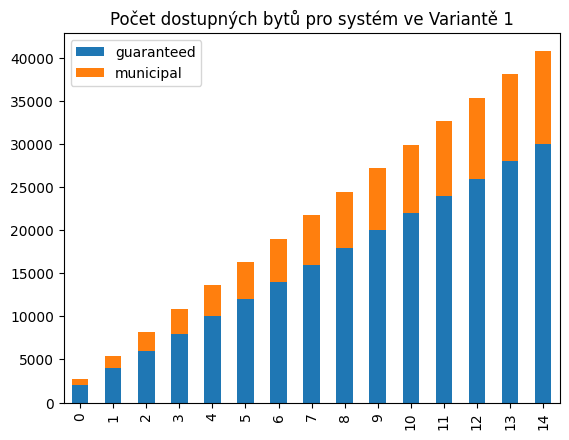

In [5]:
guaranteed_yearly_apartments = 2000
municipal_apartments_today = 161100
municipal_yearly_new_apartments = 300
municipal_existing_availability_rate = 0.004
municipal_new_availability_rate = 0.25

simulate_apartment_stock(
        guaranteed_yearly_apartments=guaranteed_yearly_apartments,
        municipal_apartments_today=municipal_apartments_today,
        municipal_yearly_new_apartments=municipal_yearly_new_apartments,
        municipal_existing_availability_rate=municipal_existing_availability_rate,
        municipal_new_availability_rate=municipal_new_availability_rate,
        years=years
    ).plot.bar(stacked=True, title='Počet dostupných bytů pro systém ve Variantě 1')

## Intervence a průchod domácnosti systémem

V každém roce proběhnou operace v následujícm sledu: 


1. Určení velikosti fronty (započítání relapses z minulého roku)
2. Měkké intervence (vždy podíl zbývajících domácností daného typu na frontě)
    1. `self_help` - některé domácnosti si zvládnou pomoci samy a dostanou se ven z BN
    2. `consulting` - další část domácností přijde pro poradenství na KMB a díky tomu se zvládnou dostat ven z BN
    3. `mop_payment` - další část domácností po konzultaci na KMB dostane vyplacenou dávku MOP
3. Bytové intervence (vždy porovnání počtu domácností daného typu ve frontě s počtem dostupných bytů)
    1. `Low risk` domácnosti do `guaranteed` bytů
    2. `High risk` domácnosti do `municipal` bytů
    3. `High risk` domácnosti do `guaranteed` bytů
    4. `Low risk` domácnosti do `municipal` bytů 

 Je třeba si uvědomit, že uvedené podíly se aplikují postupně a tedy postupně ubývá základ vůči kterému se podíly aplikují

 ### Intervenční podíly pro měkké intervence
 #### Varianta 0

In [6]:
intervention_shares_v0 = pd.Series({
    ('low','self_help'):.4, #
    ('low','consulting'):.0,
    ('low','mop_payment'):.02,
    ('high','self_help'):.15,
    ('high','consulting'):.0,
    ('high','mop_payment'):.02
}).unstack()
intervention_shares_v0

,consulting,mop_payment,self_help
high,0.0,0.02,0.15
low,0.0,0.02,0.40


#### Varianta 1 

In [7]:
intervention_shares_v1 = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.1,
    ('low','mop_payment'):.2,
    ('high','self_help'):.1,
    ('high','consulting'):.05,
    ('high','mop_payment'):.1
}).unstack()
intervention_shares_v1

,consulting,mop_payment,self_help
high,0.05,0.1,0.1
low,0.10,0.2,0.2


### Délka intervence

* Každá intervence má jinou dobu trvání
* Zatímco měkké intervence jsou jednorázové a z pohledu modelu trvají jeden rok, bydlení trvá déle

In [8]:
years_of_support = pd.Series({
    'municipal':3, # or 5 years
    'guaranteed':2,
    'self_help':1,
    'mop_payment':1,
    'consulting':1
})
years_of_support

municipal      3
guaranteed     2
self_help      1
mop_payment    1
consulting     1
dtype: int64

### Relaps - neúspěšné intervence

* část domácností, se i přes to, že dostanou intervenci, se po čase zase vrátí do problémů
* Tomu model říká "relaps" - po konci intervenci domácnost neopouští systém, ale vrací se zpátky do fronty
* Tabulka níže ukazuje, jaká část domácností, které dostaly danou intervenci se po konci intervence vrací zpět do systému

In [9]:
relapse_rates_v1 = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.2,
    ('low','mop_payment'):.1,
    ('low','guaranteed'):.05,
    ('low','municipal'):.05,
    ('high','self_help'):.6,
    ('high','consulting'):.5,
    ('high','mop_payment'):.3,
    ('high','guaranteed'):.3,
    ('high','municipal'):.3
}).unstack()

relapse_rates_v1

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.30,0.3,0.30,0.6
low,0.2,0.05,0.1,0.05,0.2


Vyšší relapse rates reflektují nedostupnost sociální péče (TODO není empirická literature?)

In [10]:
relapse_rates_v0 =  relapse_rates_v1.copy()
relapse_rates_v0[['mop_payment','guaranteed','municipal']] = relapse_rates_v1[['mop_payment','guaranteed','municipal']] * 1.5
relapse_rates_v0

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.450,0.45,0.450,0.6
low,0.2,0.075,0.15,0.075,0.2


### Použití sociální asistence
* Sociální služby nejsou přímo modelovány, ale jsou přidělovány v určitém podílu a s měnící se délkou trvání
* Podíl intervenovaných, kteří zároveň s intervencí dostanou sociální asistenci a délku jejího trvání

#### Varianta 0

In [11]:
social_assistences_v0 = pd.Series({
    ('mop_payment','share'): .0,
    ('mop_payment','years'): 1,
    ('guaranteed','share'): .0,
    ('guaranteed','years'): 2,
    ('municipal','share'): .85,
    ('municipal','years'): 2,
}).unstack()

social_assistences_v0

,share,years
guaranteed,0.00,2.0
mop_payment,0.00,1.0
municipal,0.85,2.0


#### Varianta 1 

In [12]:
social_assistences_v1 = pd.Series({
    ('mop_payment','share'): .5,
    ('mop_payment','years'): 1,
    ('guaranteed','share'): .85,
    ('guaranteed','years'): 2,
    ('municipal','share'): .85,
    ('municipal','years'): 2,
}).unstack()

social_assistences_v1

,share,years
guaranteed,0.85,2.0
mop_payment,0.50,1.0
municipal,0.85,2.0


### Náklady intervencí

* Rozlišujeme tři druhy nákladů:
    * **Jednorázové** - Náklady, které je potřeba zadat pouze jednou - napříkald vývoj IT systému
    * **Fixní** - náklady existence systému sociálního bydlení, zcela nezávislé na výkonu - např. provoz IT systému.
    * **Vstupní** - náklady provedení intervence - například sehnání bytu do systému či vyplacení MOP
    * **Průběžné/Roční** - náklady probíhající intervence - náklady bytu


In [13]:
discount_rate = 0.04 # Impact assessment guidelines European Commission https://ec.europa.eu/smart-regulation/impact/commission_guidelines/docs/131210_cba_study_sg_final.pdf
intervention_costs_v1 = pd.Series({
    ('entry','self_help'):0,
    ('entry','mop_payment'):38200,
    ('entry','guaranteed'):16000, # Nezahrnuje poradenství - to je vyjádřeno fixní roční částkou
    ('entry','municipal'):0, # Nezahrnuje poradenství - to je vyjádřeno fixní roční částkou
    ('entry', 'social_assistance'): 0,
    ('yearly','self_help'):0,
    ('yearly','mop_payment'):0,
    ('yearly','guaranteed'):48333,
    ('yearly','municipal'):51333,
    ('yearly','social_assistance'): 80000,
    ('yearly','queue_budget'): 2.36*20303, #47915, # https://drive.google.com/drive/u/0/folders/1AB-eICOTy3LndCi75t68i2aCKKgxXlrd p.47
    ('yearly','queue_social'): 146712,
    ('one_off','IT_system'):10000000,
    ('yearly','IT_system'):2000000,
    ('yearly','regional_administration'):113925000,
    ('yearly','consulting'):419000000
}).unstack()
intervention_costs_v1.T

,entry,one_off,yearly
IT_system,NaN,10000000.0,2.000000e+06
consulting,NaN,NaN,4.190000e+08
guaranteed,16000.0,NaN,4.833300e+04
mop_payment,38200.0,NaN,0.000000e+00
municipal,0.0,NaN,5.133300e+04
queue_budget,NaN,NaN,4.791508e+04
queue_social,NaN,NaN,1.467120e+05
regional_administration,NaN,NaN,1.139250e+08
self_help,0.0,NaN,0.000000e+00
social_assistance,0.0,NaN,8.000000e+04


In [14]:
intervention_costs_v0 = intervention_costs_v1.copy()
intervention_costs_v0.loc ['yearly','IT_system'] = 0
intervention_costs_v0.loc ['yearly','regional_administration'] = 0
intervention_costs_v0.loc ['yearly','consulting'] = 0
intervention_costs_v0.loc ['one_off','IT_system'] = 0

## Balíčky parametrů specifikujících varianty

### Varianta 0: Bez zákona

In [15]:
INPUT_0_OPTIMISTIC = {
    'title': '0: Bez zákona (optimistická)',
    'years':years,
    'years_of_support':years_of_support,
    'intervention_costs':intervention_costs_v0,
    'guaranteed_yearly_apartments':0, 
    'municipal_apartments_today': municipal_apartments_today,
    'municipal_yearly_new_apartments': municipal_yearly_new_apartments,
    'municipal_existing_availability_rate': .002,
    'municipal_new_availability_rate': .1, 
    'relapse_rates':relapse_rates_v0,
    'intervention_shares':intervention_shares_v0,
    'hhs_inflow':hhs_inflow_optimistic,
    'social_assistences':social_assistences_v0,
    'discount_rate':discount_rate
}
OUTPUT_0_OPTIMISTIC = simulate_social_housing(**INPUT_0_OPTIMISTIC)
OUTPUT_0_OPTIMISTIC.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'title'])

In [16]:
INPUT_0_PESIMISTIC = copy.deepcopy(INPUT_0_OPTIMISTIC)
INPUT_0_PESIMISTIC['title'] = '0: Bez zákona'
INPUT_0_PESIMISTIC['hhs_inflow'] = hhs_inflow_pesimistic

OUTPUT_0_PESIMISTIC = simulate_social_housing(**INPUT_0_PESIMISTIC)
OUTPUT_0_PESIMISTIC.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'title'])

### Varianta 1: Mix opatření

In [17]:
INPUT_1_OPTIMISTIC = {
    'title': '1: Mix opatření (optimistická)',
    'years':years,
    'years_of_support':years_of_support,
    'intervention_costs':intervention_costs_v1,
    'guaranteed_yearly_apartments':2000,
    'municipal_apartments_today': municipal_apartments_today,
    'municipal_yearly_new_apartments': municipal_yearly_new_apartments, 
    'municipal_existing_availability_rate': .004,
    'municipal_new_availability_rate': .25,
    'relapse_rates':relapse_rates_v1,
    'intervention_shares':intervention_shares_v1,
    'hhs_inflow':hhs_inflow_optimistic,
    'social_assistences':social_assistences_v1,
    'discount_rate':discount_rate  
}

OUTPUT_1_OPTIMISTIC = simulate_social_housing(**INPUT_1_OPTIMISTIC)
OUTPUT_1_OPTIMISTIC.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'title'])

In [18]:
INPUT_1_PESIMISTIC = copy.deepcopy(INPUT_1_OPTIMISTIC)
INPUT_1_PESIMISTIC['title'] = '1: Mix opatření'
INPUT_1_PESIMISTIC['hhs_inflow'] = hhs_inflow_pesimistic
OUTPUT_1_PESIMISTIC = simulate_social_housing(**INPUT_1_PESIMISTIC)
OUTPUT_1_PESIMISTIC.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'title'])

### Varianta 2: Pouze měkká opatření

In [19]:
INPUT_2_OPTIMISTIC = copy.deepcopy(INPUT_1_OPTIMISTIC)
INPUT_2_OPTIMISTIC['title'] = '2: Pouze poradenství a sociální služby (optimistická)'

INPUT_2_OPTIMISTIC['guaranteed_yearly_apartments'] = INPUT_0_OPTIMISTIC['guaranteed_yearly_apartments']
INPUT_2_OPTIMISTIC['municipal_existing_availability_rate'] = INPUT_0_OPTIMISTIC['municipal_existing_availability_rate']
INPUT_2_OPTIMISTIC['municipal_new_availability_rate'] = INPUT_0_OPTIMISTIC['municipal_new_availability_rate']

# Dvakrát větší riziko relapsu u jediného reálného nástroje - tj. MOP
#INPUT_2_OPTIMISTIC['relapse_rates'] = relapse_rates_v1
#INPUT_2_OPTIMISTIC['relapse_rates'].loc['low','mop_payment'] = 0.2

OUTPUT_2_OPTIMISTIC = simulate_social_housing(**INPUT_2_OPTIMISTIC)
OUTPUT_2_OPTIMISTIC.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'title'])

In [20]:
INPUT_2_PESIMISTIC = copy.deepcopy(INPUT_2_OPTIMISTIC)
INPUT_2_PESIMISTIC['title'] = '2: Pouze poradenství a sociální služby'
INPUT_2_PESIMISTIC['hhs_inflow'] = hhs_inflow_pesimistic
OUTPUT_2_PESIMISTIC = simulate_social_housing(**INPUT_2_PESIMISTIC)
OUTPUT_2_PESIMISTIC.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'title'])

### Varianta 3: Pouze bydlení

In [21]:
INPUT_3_OPTIMISTIC = copy.deepcopy(INPUT_1_OPTIMISTIC)
INPUT_3_OPTIMISTIC['title'] = '3: Pouze bydlení (optimistická)'

INPUT_3_OPTIMISTIC['guaranteed_yearly_apartments'] = INPUT_3_OPTIMISTIC['guaranteed_yearly_apartments'] * 0.5

INPUT_3_OPTIMISTIC['relapse_rates'] = relapse_rates_v0
INPUT_3_OPTIMISTIC['intervention_shares'] = intervention_shares_v0
INPUT_3_OPTIMISTIC['intervention_costs'] = intervention_costs_v0
INPUT_3_OPTIMISTIC['social_assistences'] = social_assistences_v0

OUTPUT_3_OPTIMISTIC = simulate_social_housing(**INPUT_3_OPTIMISTIC)
OUTPUT_3_OPTIMISTIC.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'title'])

In [22]:
INPUT_3_PESIMISTIC = copy.deepcopy(INPUT_3_OPTIMISTIC)
INPUT_3_PESIMISTIC['title'] = '3: Pouze bydlení'
INPUT_3_PESIMISTIC['hhs_inflow'] = hhs_inflow_pesimistic
OUTPUT_3_PESIMISTIC = simulate_social_housing(**INPUT_3_PESIMISTIC)
OUTPUT_3_PESIMISTIC.keys()

dict_keys(['interventions', 'hhs', 'returnees', 'costs', 'costs_units', 'costs_discounted', 'title'])

In [23]:
pesimistic_variants = [OUTPUT_0_PESIMISTIC, OUTPUT_1_PESIMISTIC, OUTPUT_2_PESIMISTIC, OUTPUT_3_PESIMISTIC]
optimistic_variants = [OUTPUT_0_OPTIMISTIC, OUTPUT_1_OPTIMISTIC, OUTPUT_2_OPTIMISTIC, OUTPUT_3_OPTIMISTIC]

(<Figure size 1500x1000 with 6 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ce616b850>,
       dtype=object))

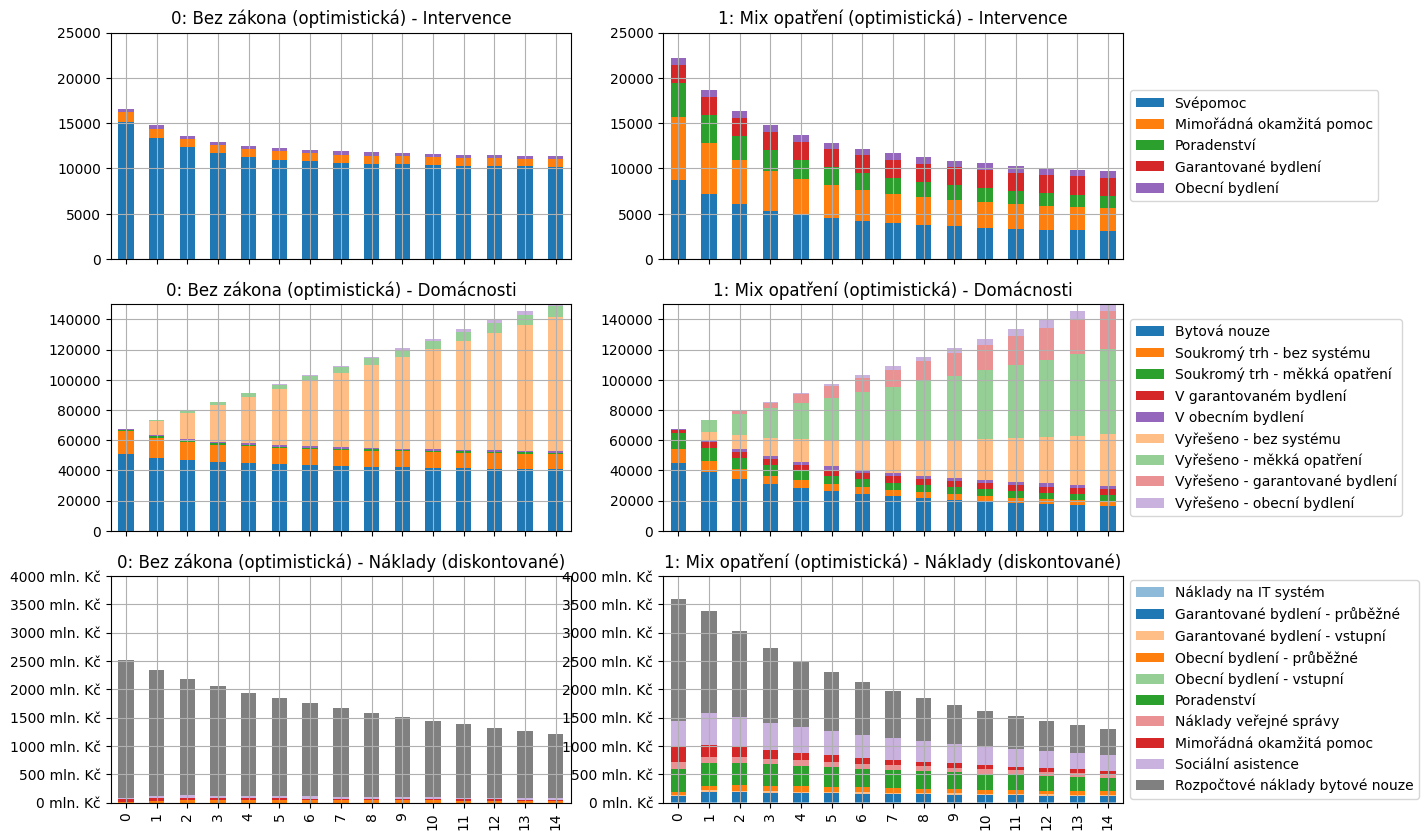

In [24]:
compare_variants(OUTPUT_0_OPTIMISTIC, OUTPUT_1_OPTIMISTIC)

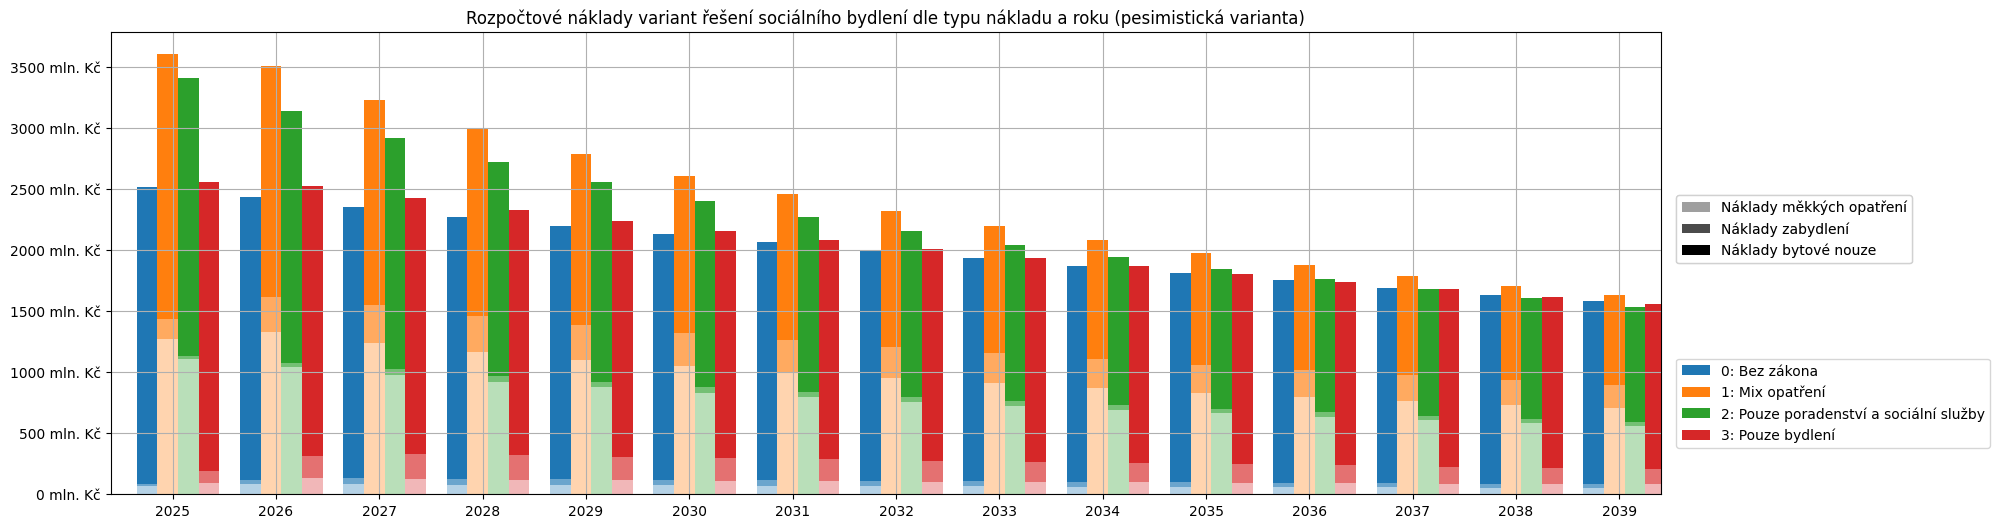

In [25]:
plot_costs_summary(
    pesimistic_variants,
    title='Rozpočtové náklady variant řešení sociálního bydlení dle typu nákladu a roku (pesimistická varianta)',
)

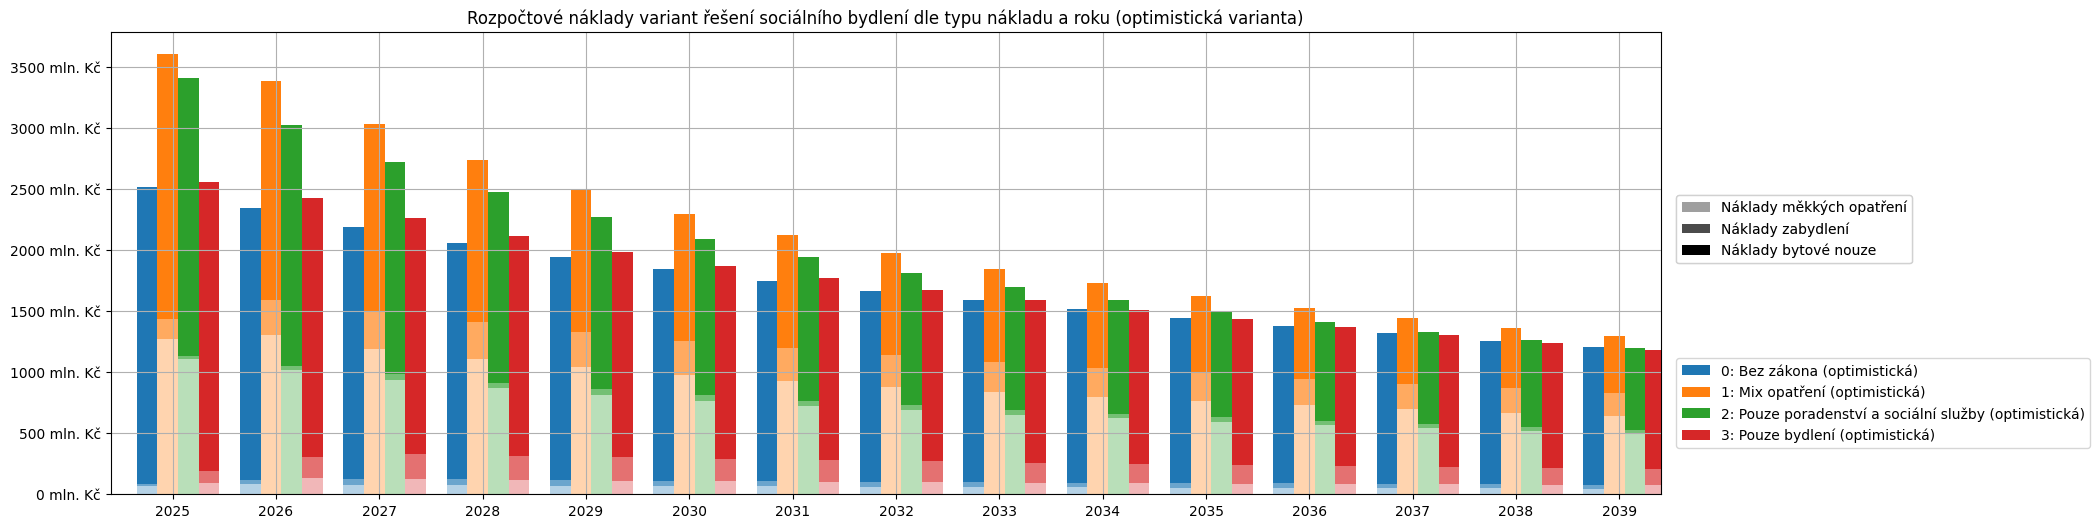

In [26]:
plot_costs_summary(
    optimistic_variants,
    title='Rozpočtové náklady variant řešení sociálního bydlení dle typu nákladu a roku (optimistická varianta)',
)

## Hlavní výsledky

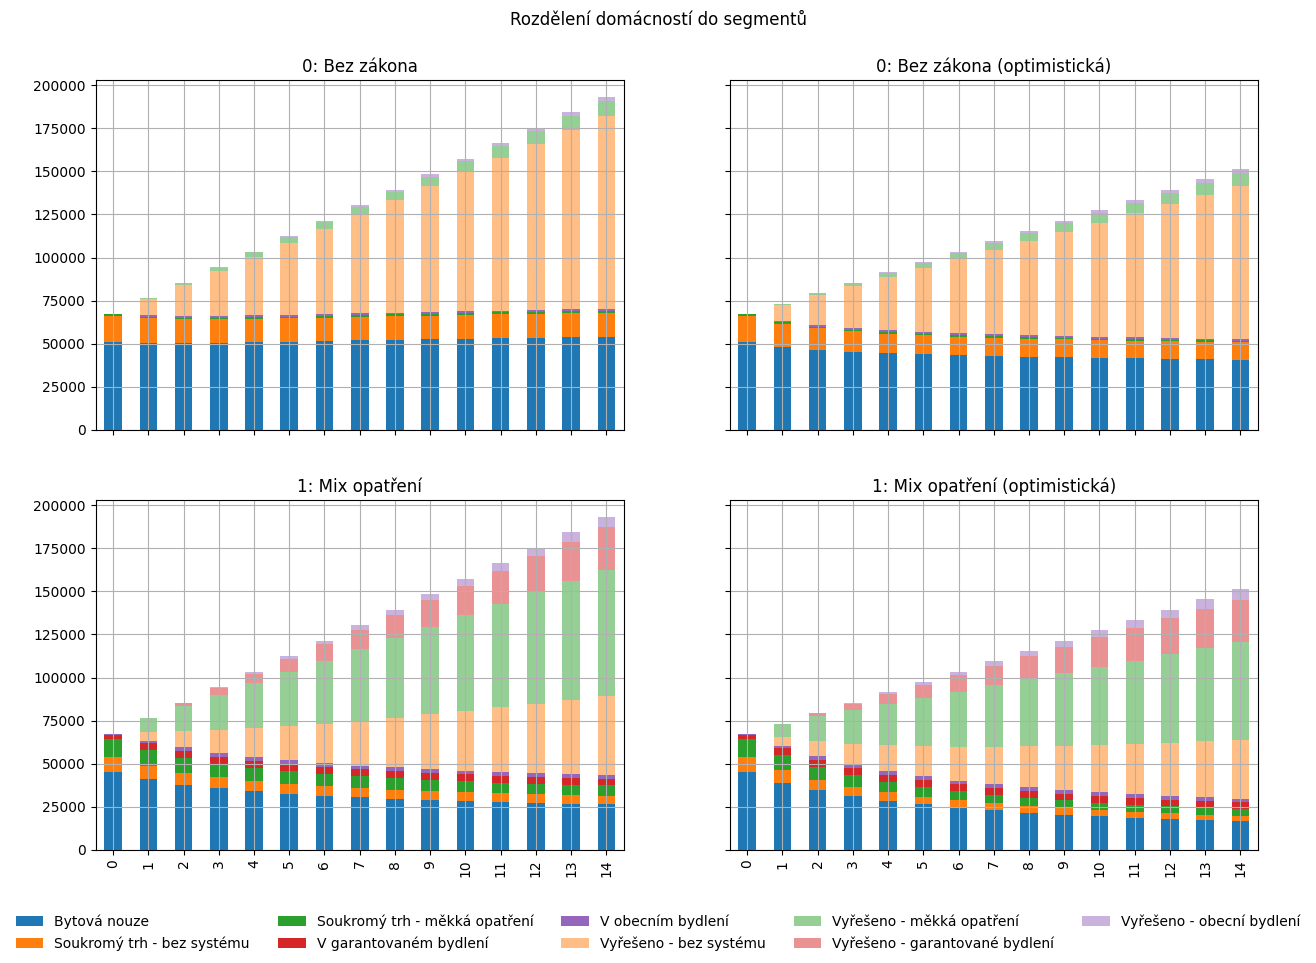

In [27]:
plot_4_variants(
    tables_1A=OUTPUT_0_PESIMISTIC, 
    tables_1B=OUTPUT_1_PESIMISTIC, 
    tables_2A=OUTPUT_0_OPTIMISTIC, 
    tables_2B=OUTPUT_1_OPTIMISTIC, 
    plot_function = 'plot_hhs'
);

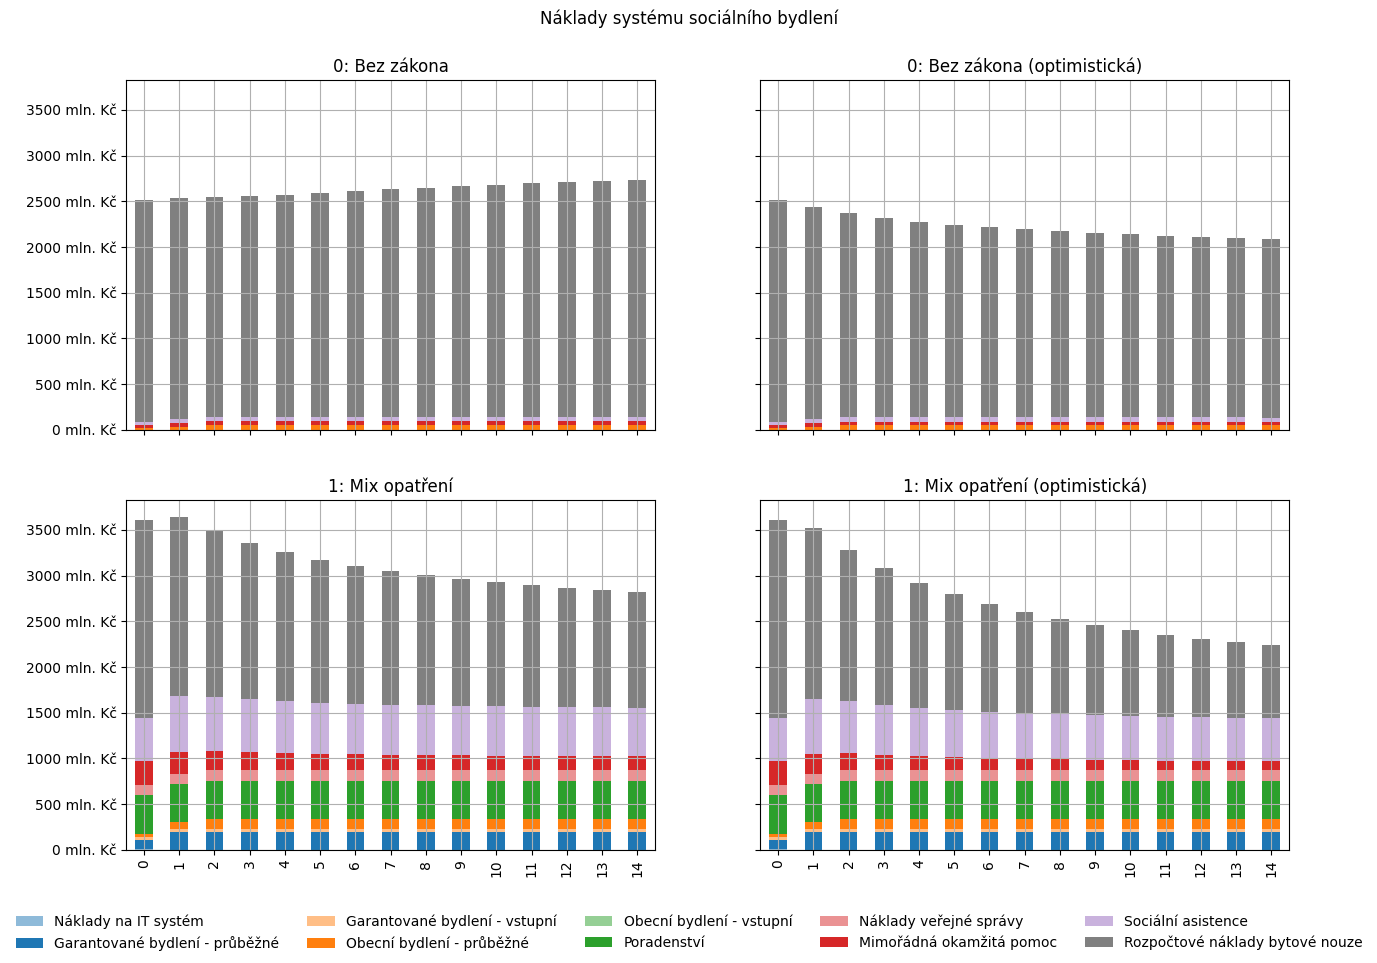

In [28]:
plot_4_variants(
    tables_1A=OUTPUT_0_PESIMISTIC, 
    tables_1B=OUTPUT_1_PESIMISTIC, 
    tables_2A=OUTPUT_0_OPTIMISTIC, 
    tables_2B=OUTPUT_1_OPTIMISTIC, 
    plot_function = 'plot_costs'
);

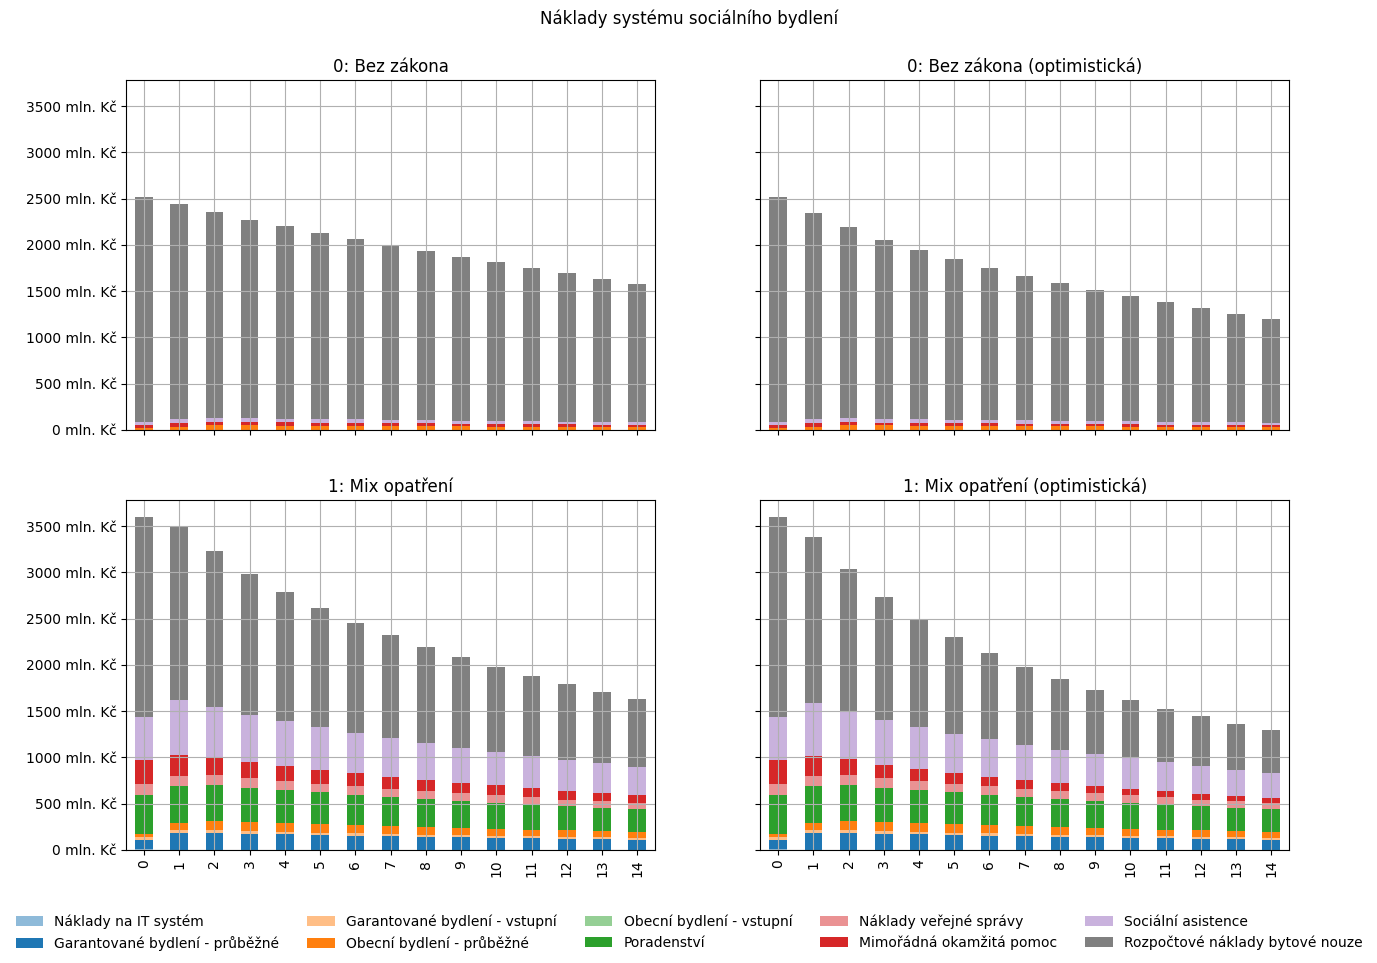

In [29]:
plot_4_variants(
    tables_1A=OUTPUT_0_PESIMISTIC, 
    tables_1B=OUTPUT_1_PESIMISTIC, 
    tables_2A=OUTPUT_0_OPTIMISTIC, 
    tables_2B=OUTPUT_1_OPTIMISTIC, 
    plot_function = 'plot_costs_discounted'
);

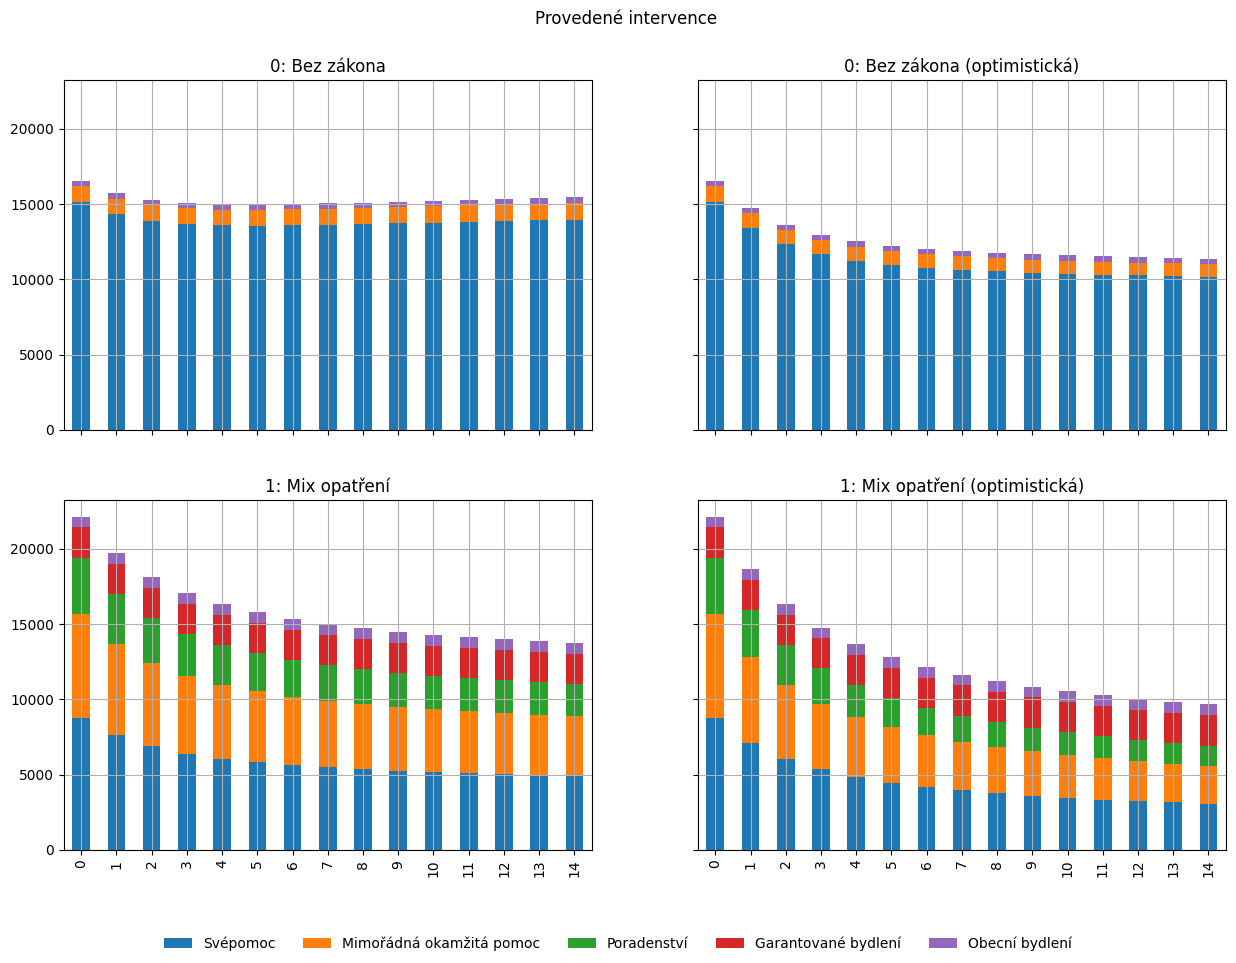

In [30]:
plot_4_variants(
    tables_1A=OUTPUT_0_PESIMISTIC, 
    tables_1B=OUTPUT_1_PESIMISTIC, 
    tables_2A=OUTPUT_0_OPTIMISTIC, 
    tables_2B=OUTPUT_1_OPTIMISTIC, 
    plot_function = 'plot_interventions'
);

### Pro podrobnější zkoumání lze exportovat data z jednotlivých simulací do XLSX

In [31]:
save_tables_to_excel(
    [OUTPUT_0_PESIMISTIC, OUTPUT_1_PESIMISTIC, OUTPUT_0_OPTIMISTIC, OUTPUT_1_OPTIMISTIC],
    'hlavni_varianty.xlsx'
)

## Detailní srovnání variant

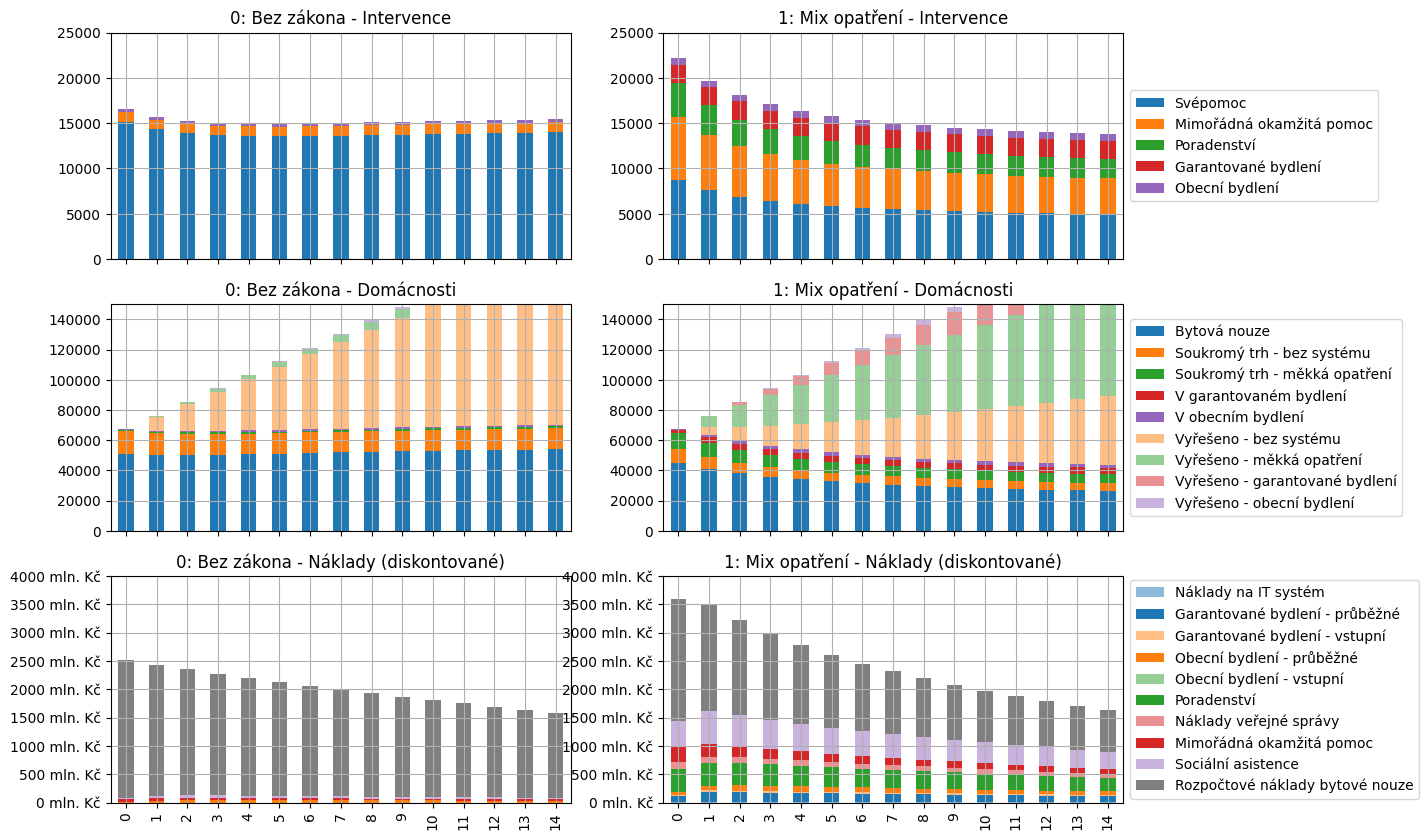

In [32]:
compare_variants(OUTPUT_0_PESIMISTIC, OUTPUT_1_PESIMISTIC);

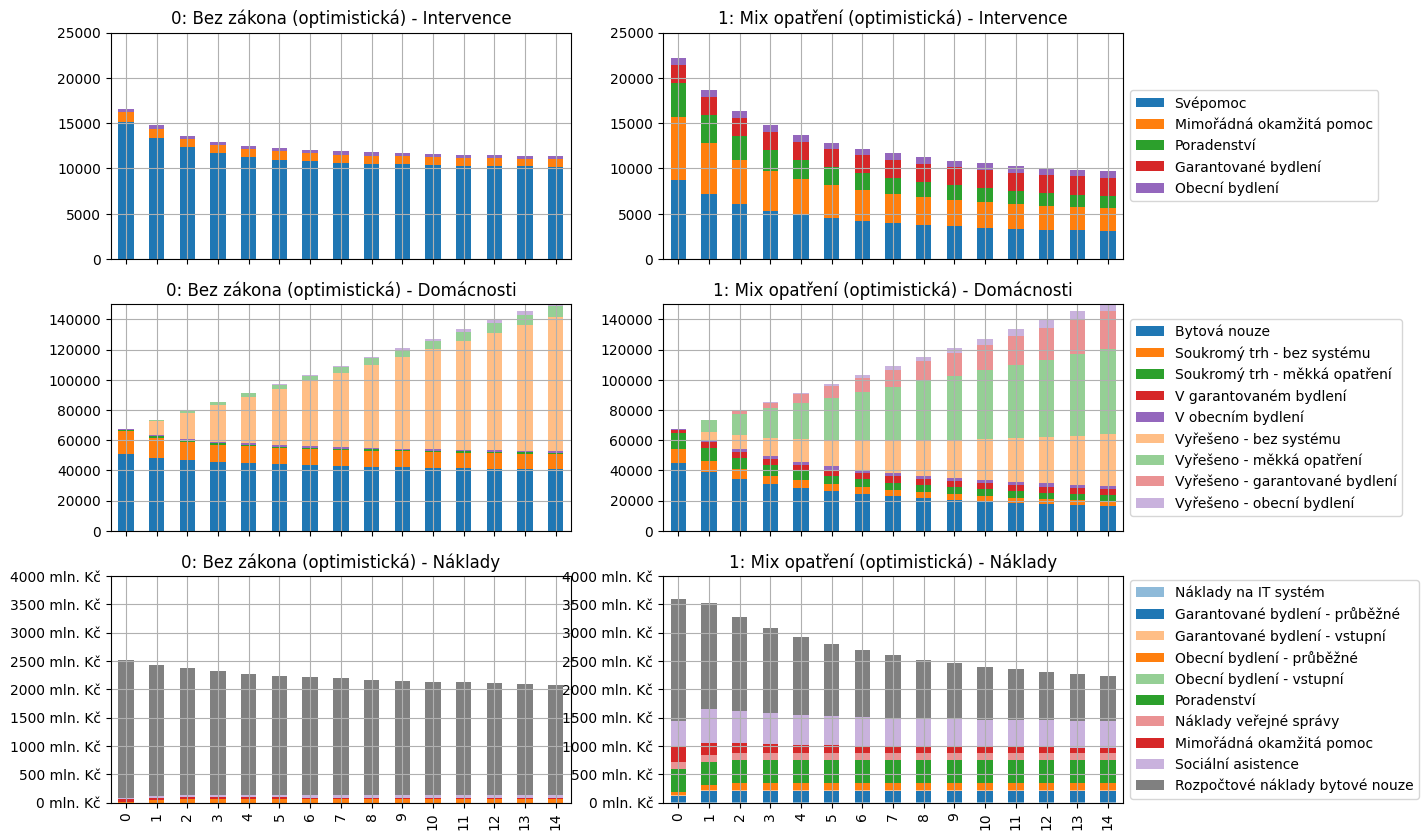

In [33]:
compare_variants(OUTPUT_0_OPTIMISTIC, OUTPUT_1_OPTIMISTIC, discount_costs=False);

## Příklad: Častější MOPky

In [34]:
default_variant = copy.deepcopy(VARIANT_1_OPTIMISTIC)
default_variant['title'] = 'Podíl MOP: 10 % u high a 20 % u low'

variant_more_mops = copy.deepcopy(default_variant)
variant_more_mops['intervention_shares'].loc['high','mop_payment'] = variant_more_mops['intervention_shares'].loc['high','mop_payment'] * 2
variant_more_mops['intervention_shares'].loc['low','mop_payment'] = variant_more_mops['intervention_shares'].loc['low','mop_payment'] * 2
variant_more_mops['title'] = 'Podíl MOP: 20 % u high a 40 % u low'

compare_variants(default_variant, variant_more_mops);

NameError: name 'VARIANT_1_OPTIMISTIC' is not defined

### Příklad: Intenzivnější výstavba obecních bytů

In [ ]:
default_variant = copy.deepcopy(VARIANT_1_OPTIMISTIC)
default_variant['title'] = 'Obecní výstavba: 300 nových bytů ročně'

variant_more_municipals = copy.deepcopy(default_variant)
variant_more_municipals['municipal_yearly_new_apartments'] = 1000
variant_more_municipals['title'] = 'Obecní výstavba: 1000 nových bytů ročně'

compare_variants(default_variant, variant_more_municipals);

### Příklad: Vliv diskontování

In [ ]:
default_variant = copy.deepcopy(VARIANT_1_OPTIMISTIC)
default_variant['title'] = 'Diskontní míra: 3,5 %'

variant_higher_discount_rate = copy.deepcopy(default_variant)
variant_higher_discount_rate['discount_rate'] = 0.05
variant_higher_discount_rate['title'] = 'Diskontní míra: 5 %'

compare_variants(default_variant, variant_higher_discount_rate);

### Pokus shrnující plot skrze domácnost

In [ ]:
def plot_hhs_in_emergency(variants, title='Počet domácností v bytové nouzi', base_year=2025):
    hhs = pd.concat([variant['hhs'].assign(varianta=variant['title'],rok=lambda row: pd.Series(row.index) + base_year) for variant in variants]).set_index(['varianta', 'rok']).rename({'low':'Nízké riziko','high':'Vysoké riziko'},axis=1)
    
    summary = hhs['queue']#.plot.bar(stacked=True,figsize=(20,6),grid=True)
    return plot_grouped_stacked(summary,title = title)
    
plot_hhs_in_emergency(optimistic_variants);

### Grafíky pro Vítka Lesáka
### Počet jednotlivých intervencí

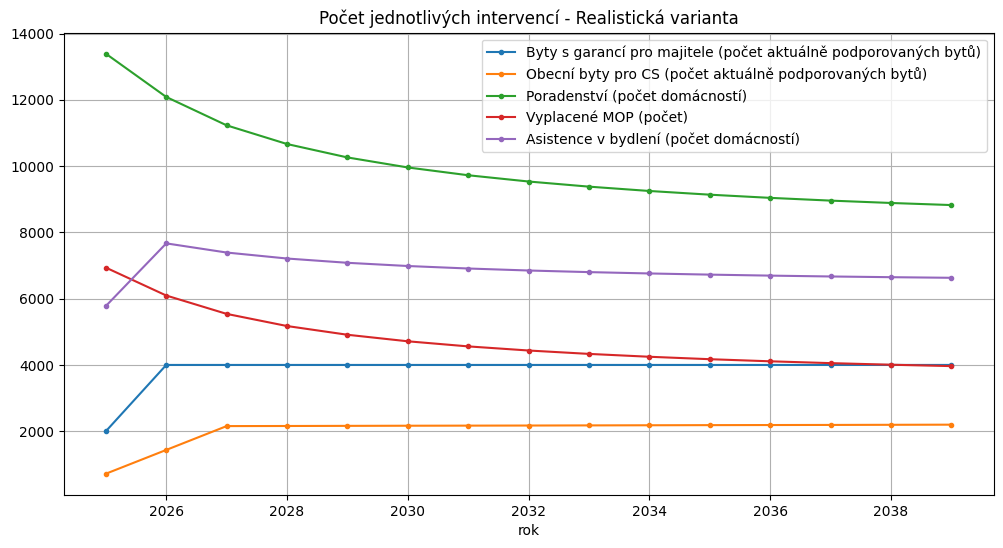

In [35]:
def get_interventions_counts(model_output, title, base_year=2025):
    df = model_output['costs_units'].assign(rok=lambda row: pd.Series(row.index) + base_year).set_index('rok')
    return pd.DataFrame({
        'Byty s garancí pro majitele (počet aktuálně podporovaných bytů)': df.apartments_yearly_guaranteed,
        'Obecní byty pro CS (počet aktuálně podporovaných bytů)':  df.apartments_yearly_municipal,
        'Poradenství (počet domácností)': df.consulting,
        'Vyplacené MOP (počet)': df.mop_payment,
        'Asistence v bydlení (počet domácností)': df.social_assistance
    }).plot.line(
        style='.-',
        grid=True,
        figsize=(12,6),
        title=title
    )

get_interventions_counts(OUTPUT_1_PESIMISTIC, title='Počet jednotlivých intervencí - Realistická varianta')

#### Celkové náklady na opatření a bytovou nouzi

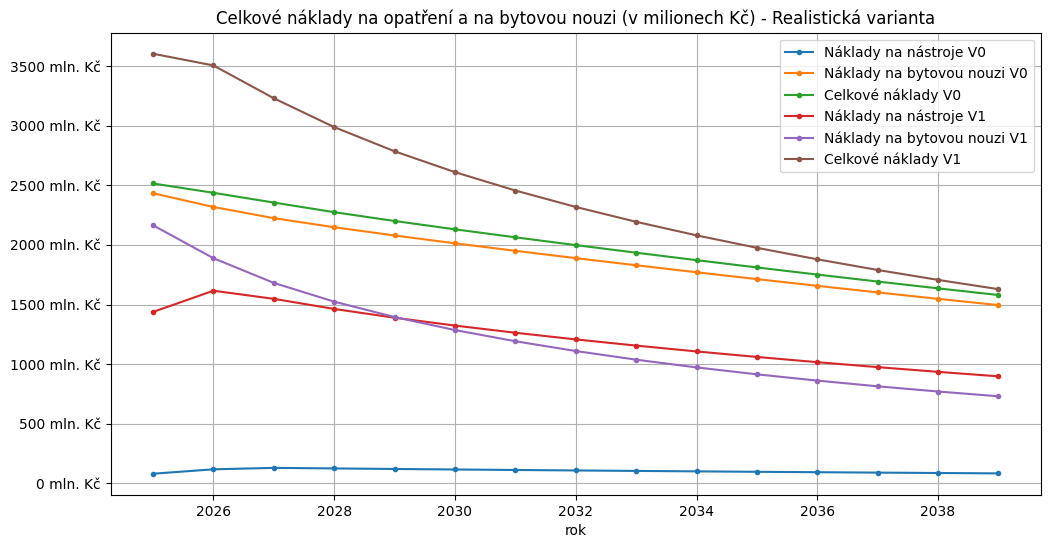

In [36]:
def plot_total_costs(model_output_v0,model_output_v1, title, base_year=2025, costs_type='costs_discounted'):
    v0 = model_output_v0[costs_type].assign(rok=lambda row: pd.Series(row.index) + base_year).set_index('rok')
    v1 = model_output_v1[costs_type].assign(rok=lambda row: pd.Series(row.index) + base_year).set_index('rok')
    
    interventions = ['IT_system','apartments_yearly_guaranteed','apartments_entry_guaranteed','apartments_yearly_municipal','apartments_entry_municipal','consulting','regional_administration','mop_payment','social_assistence']
    
    ax = pd.DataFrame({
        'Náklady na nástroje V0':v0[interventions].sum(axis=1),
        'Náklady na bytovou nouzi V0':v0.queue_budget,
        'Celkové náklady V0':v0[interventions].sum(axis=1) + v0.queue_budget,
        'Náklady na nástroje V1':v1[interventions].sum(axis=1),
        'Náklady na bytovou nouzi V1':v1.queue_budget,
        'Celkové náklady V1':v1[interventions].sum(axis=1) + v1.queue_budget
    }).plot.line(
        style='.-',
        grid=True,
        figsize=(12,6),
        title=title
    )
    ax.yaxis.set_major_formatter(MLN_FORMATTER)
    return ax
plot_total_costs(OUTPUT_0_PESIMISTIC, OUTPUT_1_PESIMISTIC, title='Celkové náklady na opatření a na bytovou nouzi (v milionech Kč) - Realistická varianta')

#### Náklady na opatření v zákoně (v milionech Kč) - Realistická varianta, bez zohlednění nákladů na Variantu 0 (bez zákona)

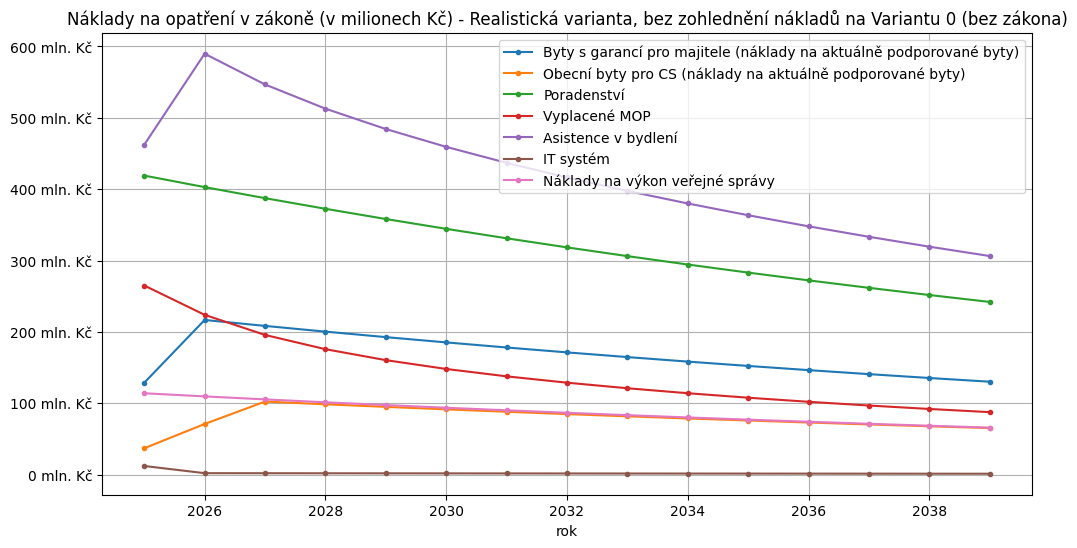

In [37]:
def plot_interventions_costs(model_output, title, base_year=2025, costs_type='costs_discounted'):
    df = model_output[costs_type].assign(rok=lambda row: pd.Series(row.index) + base_year).set_index('rok')
    ax = pd.DataFrame({
        'Byty s garancí pro majitele (náklady na aktuálně podporované byty)': df.apartments_yearly_guaranteed + df.apartments_entry_guaranteed,
        'Obecní byty pro CS (náklady na aktuálně podporované byty)':  df.apartments_yearly_municipal + df.apartments_entry_municipal,
        'Poradenství': df.consulting,
        'Vyplacené MOP': df.mop_payment,
        'Asistence v bydlení': df.social_assistence,
        'IT systém': df.IT_system,
        'Náklady na výkon veřejné správy': df.regional_administration
    }).plot.line(
        style='.-',
        grid=True,
        figsize=(12,6),
        title=title
    )
    
    ax.yaxis.set_major_formatter(MLN_FORMATTER)
    return ax
plot_interventions_costs(OUTPUT_1_PESIMISTIC, title='Náklady na opatření v zákoně (v milionech Kč) - Realistická varianta, bez zohlednění nákladů na Variantu 0 (bez zákona)')

### Shrnutí vstupů dle intervencí (tabulky do RIA)

#### Intervention share

In [ ]:
intervention = 'self_help'
optimistic_inputs = [INPUT_0_PESIMISTIC, INPUT_1_PESIMISTIC, INPUT_2_PESIMISTIC, INPUT_3_PESIMISTIC]

pd.concat({variant['title']:variant['intervention_shares'][intervention] for variant in optimistic_inputs},axis=1).T[['low','high']]

In [ ]:
intervention = 'self_help'
optimistic_inputs = [INPUT_0_OPTIMISTIC, INPUT_1_OPTIMISTIC, INPUT_2_OPTIMISTIC, INPUT_3_OPTIMISTIC]


pd.concat({variant['title']:variant['relapse_rates'][intervention] for variant in optimistic_inputs},axis=1).T[['low','high']]

In [ ]:
INPUT_0_OPTIMISTIC['social_assistences']

In [ ]:
intervention = 'mop_payment'
optimistic_inputs = [INPUT_0_OPTIMISTIC, INPUT_1_OPTIMISTIC, INPUT_2_OPTIMISTIC, INPUT_3_OPTIMISTIC]


pd.concat({variant['title']:variant['social_assistences'].loc[intervention] for variant in optimistic_inputs},axis=1).T

### 